In [1]:
import gym, math, tqdm, numpy as np, matplotlib.pyplot as plt

In [2]:
# Criando o ambiente
env_name = 'CartPole-v0'
env = gym.make(env_name)

In [3]:
# Isso é para garantir o mesmo ambiente de execução toda vez.
seed_val = 369
env.seed(seed_val)
np.random.seed(seed_val)

In [4]:
# Definição de parâmetros
discrete = (1, 1, 50, 50)
num_eps = 3000
epsilon, min_epsilon = 0.0, 0.1

# Alpha corresponde à TAXA DE APRENDIZADO
alpha, min_alpha = 0.0, 0.3

gamma = 0.95
decay = 15
lower = [env.observation_space.low[0], -0.05, env.observation_space.low[2], -math.radians(50) / 1.]
upper = [env.observation_space.high[0], 0.05, env.observation_space.high[2], math.radians(50) / 1.]

# Inicializando a QTable
qtable = np.zeros(discrete + (env.action_space.n, ))

In [5]:
def choose_action(state):
    """
        O fator aleatório para melhorar o aprendizado
    """
    if (np.random.random() < epsilon):
        return env.action_space.sample()
    else:
        return np.argmax(qtable[state])
# ---------------------------------------------------------------------#
def discrete_state(state):
    """
        Recebe um espaço de observação (observation space) e o discretiza
    """
    d = list()

    for i in range(len(state)):
        stepsize = (state[i] + abs(lower[i])) / (upper[i] - lower[i])
        new_state = int(round((discrete[i] - 1) * stepsize))
        new_state = min(discrete[i] - 1, max(0, new_state))
        d.append(new_state)

    return tuple(d)
# ---------------------------------------------------------------------#
def get_epsilon(ep):
    # vai reduzindo o epsilon para diminuir a ganância do algoritmo
    # entretando, existe um valor mínimo que não reduz para garantir alguma aleatoriedade
    # reduz à medida que aumenta a quantidade de episódios
    # https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
    return max(min_epsilon, min(1., 1. - math.log10((ep + 1) / decay)))
# ---------------------------------------------------------------------#
def get_alpha(ep):
    # vai reduzindo a taxa de aprendizagem para diminuir a ganância do algoritmo
    # entretando, existe um valor mínimo que não reduz para garantir algum aprendizado
    # reduz à medida que aumenta a quantidade de episódios
    # https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
    return max(min_alpha, min(1., 1. - math.log10((ep + 1) / decay)))
# ---------------------------------------------------------------------#
def update_qtable(state1, action1, reward, state2, action2):
    qtable[state1][action1] += alpha * (reward + gamma * qtable[state2][action2] - qtable[state1][action1])

In [6]:
# Treinamento

# usado para plotar o gráfico de aprendizado
tr = []

# Treinamento SARSA
for ep in tqdm.tqdm(range(num_eps)):
    state1 = discrete_state(env.reset())
    action1 = choose_action(state1)

    alpha = get_alpha(ep)
    epsilon = get_epsilon(ep)
    done = False

    # usado para plotar o gráfico de aprendizado
    r = []

    while not done:
        # Pega o próximo estado, aka, S'
        obs, reward, done, _ = env.step(action1)
        state2 = discrete_state(obs)

        # Escolhe a ação futura baseada no estado futuro observado
        action2 = choose_action(state2)

        # Atualiza a QTable
        update_qtable(state1, action1, reward, state2, action2)

        state1 = state2
        action1 = action2

        r.append(reward)

    env.close()
    tr.append(sum(r))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 539.22it/s]


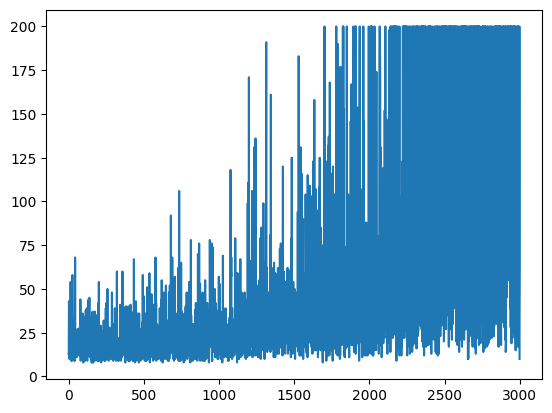

In [7]:
plt.plot(tr)

In [8]:
# Avaliando o treinamento dado

tr = []     # usado para plotar o histograma
i = 0       # macete para renderizar alguns episodios

# executando sempre para 10% de passos sobre o número total de episódios usados para treinamento
for _ in tqdm.tqdm(range(int(num_eps * 0.1))):

    # ambiente a ser avaliado
    env_t = gym.make(env_name)

    # usado para plotar o gráfico de aprendizado
    r = []

    done = False

    # estado atual
    cs = discrete_state(env_t.reset())

    while not done:

        # Renderizar os ultimos 5 episodios
        #if i >= (int(num_eps * 0.1) - 5):
            #env_t.render()

        action = np.argmax(qtable[cs])
        obs, reward, done, _ = env_t.step(action)
        new_state = discrete_state(obs)
        cs = new_state
        r.append(reward)

    i += 1
    env_t.close()
    tr.append(sum(r))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 159.73it/s]


(array([  3.,   6.,   1.,   0.,   0.,   0.,   0.,   0.,   0., 290.]),
 array([ 11. ,  29.9,  48.8,  67.7,  86.6, 105.5, 124.4, 143.3, 162.2,
        181.1, 200. ]),
 <BarContainer object of 10 artists>)

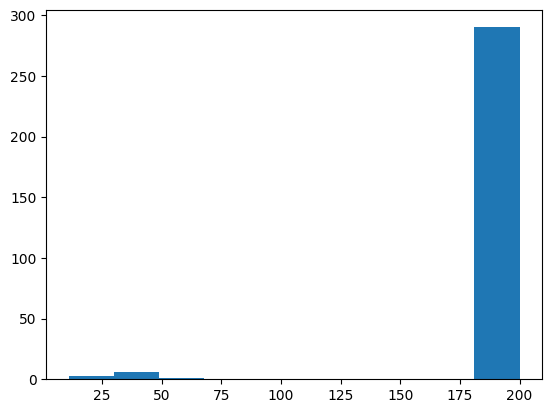

In [9]:
plt.hist(tr)